# Microsoft Studio: Box Office Analysis
**Author:** James Pheby


## Overview

Descriptive analysis of the last 15 years of box office profits to produce recommendations for Microsoft Studio on which type of movie it should produce, when it should produce it and what features the movie should include. 
-  Wait until the major markets have fully reopened after the pandemic lockdowns before releasing the movie 
-  The film should be in the thriller/horror genre
-  The film studio should try and recruit Rose Byrne and Jordan Peele to direct and write

## Business Problem

-  Maximise the likelihood of producing a profitable movie for stakeholders

-  Make efficient use of a realistic budget for the studio's debut movie

-  Recruit crew with a track record of producing profitable and acclaimed movies

-  Include features often associated with successful movies in the chosen genre

## Data Understanding
Data drawn from three sources:
-  Box office performance of more the 7,000 movies from The Numbers website
-  Genre, crew, and release date of each movie from Open Movie Database (OMDB). This also contains average user ratings from Rotten Tomatoes, Imdb and Metacritic 
-  Keywords attached to each movie from The Movie DB (TMDB)



In [1]:
from selenium import webdriver
from PIL import Image
import os
from os import path
import time
import random
import pandas as pd
import requests
import json
from pprint import pprint
import numpy as np
from wordcloud import WordCloud
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import code.visualizations as viz
import code.data_preparation as dprep

In [4]:
# global variables
# list needed to for generic dataframe queries
base_fin_col_list = ['imdb_code', 'budget_$', 'domestic_box_office_$', 'worldwide_box_office_$', 'profit_loss_$', 'return_pct', 'domestic_%', 'Genre_List']

#returns the dataframes constructed from newly scraped data
(all_financials_df, attributes_df, numbers_df) = drprep.open_files()


In [ ]:
# save dataframes at end of session
dprep.save_files()

In [ ]:
# scrape financial details from the numbers website, 
# make numbers_df, clean the data and filter for only last 15 years

numbers_df = dprep.construct__prepare_numbers_df()


In [ ]:
# use omdb api to get attributes for movies in numbers_df
# create a new df that is a copy of numbers_df but with the imdb_code, which 
# will be used as the primary key, filled in. Do this so we have a separate df
# after each time-consuming scrape/api session, so it easier to isolate different
# blocs of code to work with
# the function call also creates a global dictionary of the omdb attributes that
# will be used to create the attributes database

financials_15_df = dprep.make_omdb_dict(numbers_df)

## Data Preparation

The worldwide box office takings for the last 15 years were cleaned, so they could be stored as integers.

Any films with corrupt data, often giving corrupt release date, was filtered out in the process. 

Any movie with a budget with less than $1m was filtered out, as it is either corrupted or anomalous, with the potential to skew the return on investment figures

Any movie with takings only outside the USA, or with no worldwide takings recorded were removed, as either corrupted or not relevant to the business problem

Any other null values were treated according to the analysis, and is explained in the code

We change any N/A empty ratings into NaN in order to make the mean_rating column numerical. We can leave those in as it is not a much used column, and when it is used, it is easy to deal with them in a way most appropriate to the anlaysis

Each movie released in the last 15 years was ranked using a combination of gross box office profit and return on investment, giving a way of comparing the performance of movies with different budgets

The best ranked movies were then analysed to find the most profitable genres

Within those genres, the movies were analysed to find which actors, directors and writers were most successful, and the runtime, release month and rating classifications most associated with hits



In [ ]:
# makes a dataframe of movie attributes using omdb api, imdb key is primary key

attributes_df = dprep.make_attributes_df()

In [23]:
# make dataframe that only includes profitable films
# also eliminates all movies with no worldwide or domestic
# recorded takings (assume we are making an english speaking film)

financial_hits_df = dprep.make_hit_df(financials_15_df)

In [14]:
# do same but for flops

financials_flops_df = dprep.make_flop_df(financials_15_df)


In [27]:
# make three joined dataframes, one for each financial dataframe

(financial_attributes_join, financial_attributes_hits_join, financial_attributes_flops_join) = dprep.make_joined_dfs(financials_15_df, financials_hits_df, financials_flops_df, attributes_df)


**DATAFRAMES** <br><br>
**financials_15_df** - all financial data for numbers movies in last 15 years <br>
**financials_hits_df** - same data but filtered out loss making movies, those only succesful outside english speaking world and those with no documented figures <br>
**financials_flops_df** - same but filtered out profit making movies <br>
<br>

**JOINED**

**financial_attributes_hits_join** - hits financial data joined with attributes <br>
**financial_attributes_flops_join** - flops financial data joined with attributes <br>
**financial_attributes_join** - all financial data joined with attributes

## Data Modeling

**Line plot to visualise the yearly trend in worldwide box office takings**

In [146]:
ww_df = financial_attributes_join.groupby('release_year').sum()
ww_df['worldwide_box_office_$'] = ww_df['worldwide_box_office_$']/1000000000
ww_df = ww_df[:15]
viz.lineplotter(ww_df, "release_year", "worldwide_box_office_$", 'Worldwide box office takings for last 15 years', 'Release Year', 'Worldwide takings $b', 'worldwide_bo.png')


**Make a bar chart showing the best profit ranked films by genre**

In [163]:
genre_df = dprep.ranked_df_maker(['Genre_List'], financial_attributes_join) 

# filter out any movies where genre list is blank
genre_df = genre_df[genre_df.index != 'N/A']
viz.rank_seaborn_bar(genre_df, 'Genre_List', 'genre', "Most profitable genre by rank", 'genre_rank.png')

NameError: name 'genre_df' is not defined

**Make grouped bar chart showing number of hits and flops for major genres**

In [30]:
filtered_concat_gen_df = dprep.make_profit_loss_df(financial_attributes_join, financial_attributes_flops_join, financial_attributes_hits_join)
viz.grouped_bar_genre(filtered_concat_gen_df)

,Genre_List,All_Counts,Flop_Counts,Hit_Counts
0,Adventure,597.0,82.0,466.0
1,Thriller,413.0,86.0,270.0
2,Horror,272.0,46.0,184.0
3,Comedy,929.0,199.0,660.0
4,Action,756.0,143.0,524.0
5,Romance,348.0,89.0,230.0
6,Drama,1289.0,392.0,771.0
7,Crime,433.0,130.0,255.0


**Make bar chart showing mean budget per genre**

In [ ]:
budget_profit_bar(genre_df)

**Make grouped bar chart showing gross profits and losses for major genres**

In [ ]:
viz.p_l_gross_group_bar(financial_attributes_join)

**Make box plot to show the variance in gross profit and loss by genre**

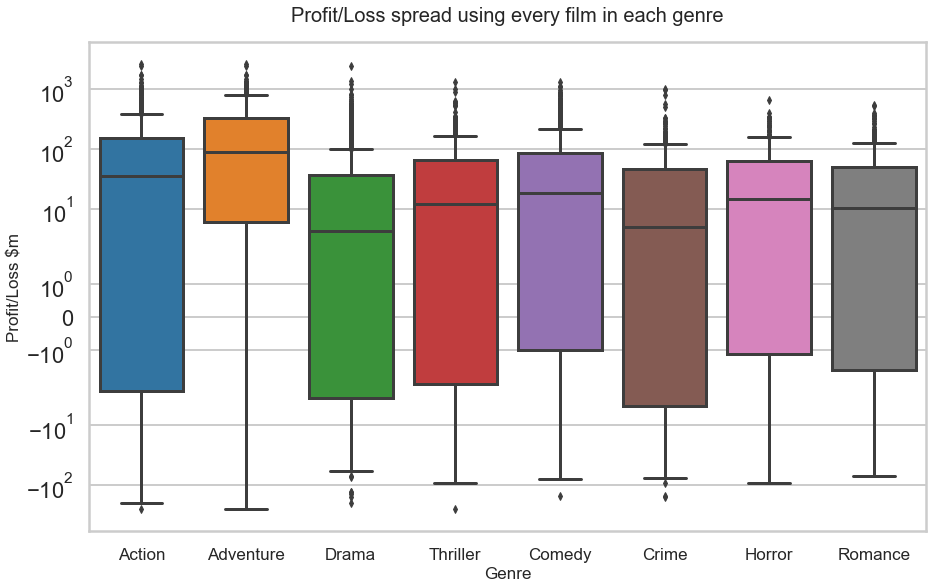

In [46]:
viz.profit_box_plot()

**Now we've made a decision that thriller is the best all round choice we focus on the hits_df as we want to find what makes a profitable movie in the genre**

**Firstly we make a lineplot showing the returns of films by budget, split into thrillers and non thrillers**

In [ ]:
viz.budget_line(financial_attributes_join)

**Make a barchart showing the best profit ranked subgenres withing he thriller genre** 

In [75]:
# creates a dataframe only showing hit thrillers
thriller_df = ranked_df_maker(['Genre_List'], financial_attributes_hits_join, ['Thriller'])  
thriller_df_sub = thriller_df.reset_index()
thriller_df_sub = thriller_df_sub[(thriller_df_sub['Genre_List'] != 'Thriller') & (thriller_df_sub['Counts'] > 20)]
viz.rank_seaborn_bar(thriller_df_sub, 'Genre_List', 'subgenre', "Most profitable subgenre by rank", 'subgenre_rank.png')

**We make a decision for a Thriller/Horror/Mystery due to all count and rank combination**

**Now find attributes most commonly associated with profitable movies in that genre**


**Make scatterplot showing return on budget for thrillers, showing values for each subgenre**

In [95]:
# make a clean thriller dataframe, not joined by genre 
add_thriller_list=[]
for index, row in financial_attributes_join.iterrows():
    if 'Thriller' in row['Genre_List']:
        add_thriller_list.append(row)
thriller_all = pd.DataFrame(add_thriller_list)
thriller_all_s = dprep.budget_prep(thriller_all)
viz.budget_sub_scatter(thriller_all_s)

,imdb_code,title,release_year,release_month,release_day,budget_$,domestic_box_office_$,worldwide_box_office_$,profit_loss_$,return_pct,...,Actor_List,Director_List,Writer_List,Rated,Run_Time,MetacriticRating,RottenRating,imdbRating,imdb_votes,mean_rating
7,tt2379713,Spectre,2015,Oct,6,300000000,200074175,879500760,579500760,193.166920,...,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],"[John Logan, Neal Purvis, Robert Wade]",PG-13,148.0,60.0,63.0,68.0,397319.0,63.666667
20,tt2382320,No Time to Die,2021,Sep,30,250000000,0,457,-249999543,-99.999817,...,"[Daniel Craig, Ana de Armas, Rami Malek]",[Cary Joji Fukunaga],"[Neal Purvis, Robert Wade, Cary Joji Fukunaga]",PG-13,163.0,NaN,NaN,NaN,0.0,NaN
24,tt0830515,Quantum of Solace,2008,Nov,14,230000000,169368427,591692078,361692078,157.257425,...,"[Daniel Craig, Olga Kurylenko, Mathieu Amalric]",[Marc Forster],"[Paul Haggis, Neal Purvis, Robert Wade]",PG-13,106.0,58.0,64.0,66.0,416692.0,62.666667
38,tt6723592,Tenet,2020,Aug,26,205000000,57929000,361875852,156875852,76.524806,...,"[John David Washington, Robert Pattinson, Eliz...",[Christopher Nolan],[Christopher Nolan],PG-13,150.0,69.0,70.0,74.0,420140.0,71.000000
49,tt1074638,Skyfall,2012,Oct,26,200000000,304360277,1110526981,910526981,455.263491,...,"[Daniel Craig, Javier Bardem, Naomie Harris]",[Sam Mendes],"[Neal Purvis, Robert Wade, John Logan]",PG-13,143.0,81.0,92.0,77.0,645955.0,83.333333


**Make bar graphs of best profit ranked actors, directors and writers popular in the genre**


In [123]:
actor_df = dprep.ranked_df_maker(['Actor_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])  
viz.rank_seaborn_bar(actor_df, 'Actor_List', 'actor', "Most profitable actors in genre by rank", 'actor_rank.png')

In [122]:
director_df = drep.ranked_df_maker(['Director_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])[:20] 
rank_seaborn_bar(director_df, 'Director_List', 'director', "Most profitable directors in genre by rank", 'director_rank.png')

In [125]:
writer_df = drep.ranked_df_maker(['Writer_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])[:20]  
viz.rank_seaborn_bar(writer_df, 'Writer_List', 'writer', "Most profitable writers in genre by rank", 'writer_rank.png')

**Make subplots showing the relative perfomances of the best performing crew members in the genre**

In [89]:
top_full_crew_df = dprep.make_crew_df(financial_attributes_join)


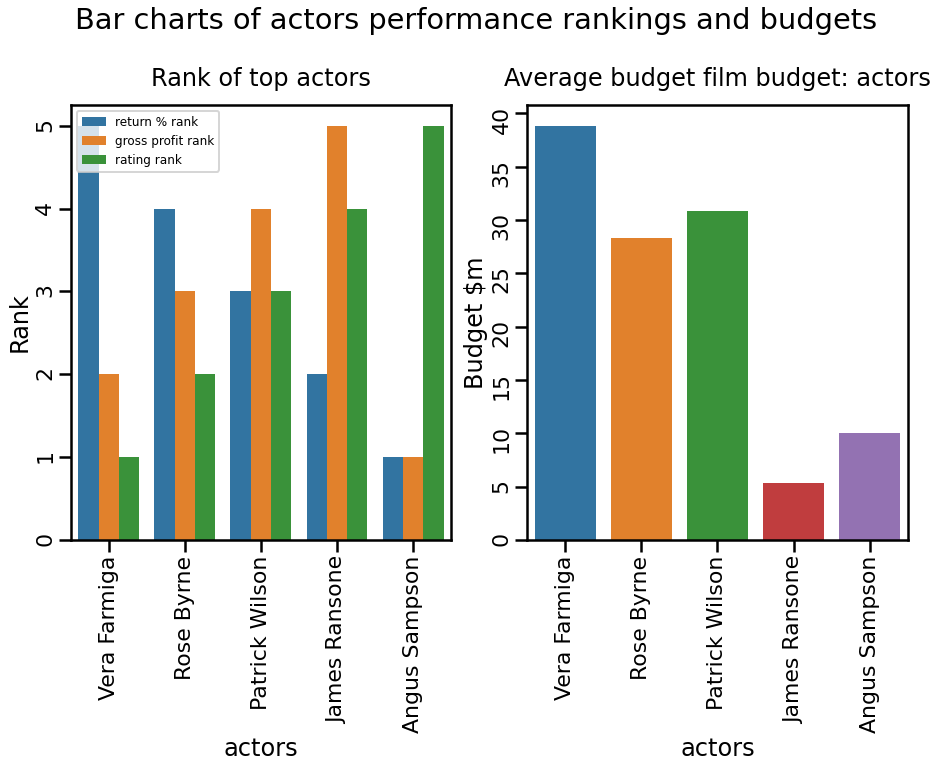

In [90]:
act_group = viz.graph_generator(top_full_crew_df, 'Actor_List', top_actors, 'actors')

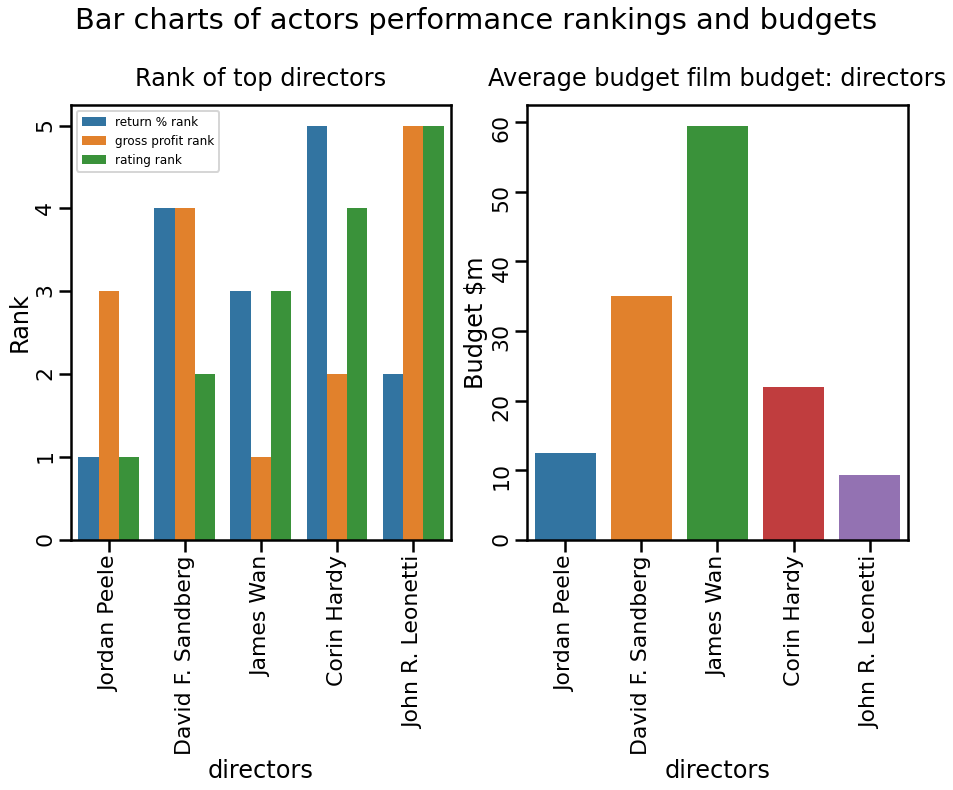

In [91]:
dir_group = viz.graph_generator(top_full_crew_df, 'Director_List', top_directors, 'directors')

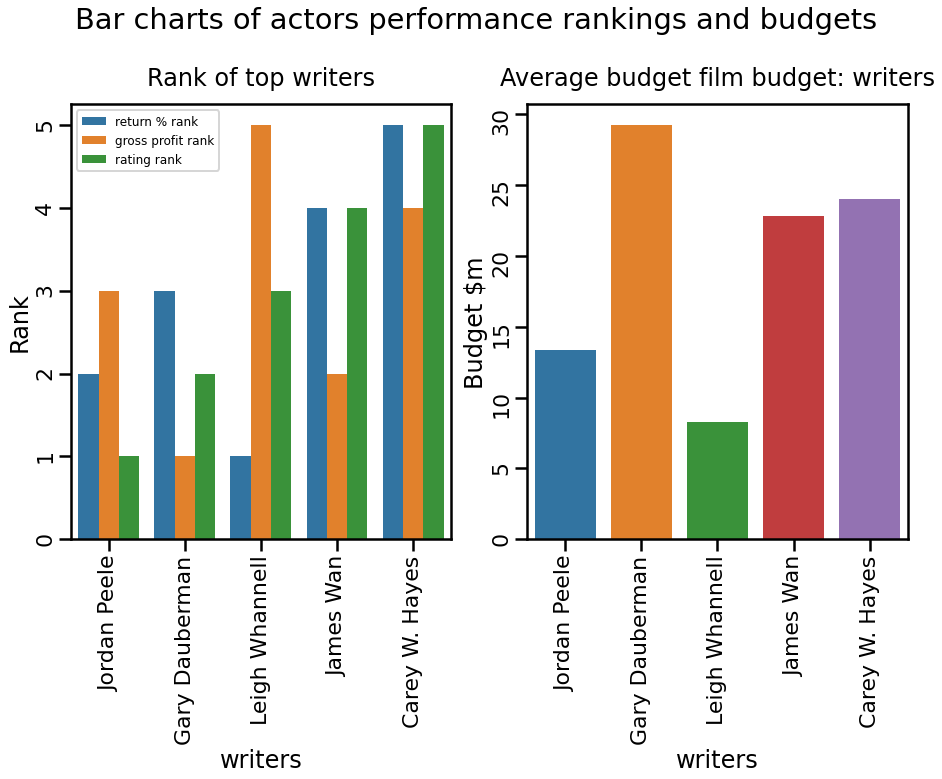

In [92]:
writer_group = viz.graph_generator(top_full_crew_df, 'Writer_List', top_writers, 'writers')

**Make plot to see link between user ratings and profitability**

In [ ]:
viz.user_rating_v_profit(financial_attributes_join)

**Make ranked bar charts showing most profitable runtime, rated, ratings and release month**


In [173]:
runtime_df = dprep.ranked_df_maker(['Run_Time'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
runtime_df = runtime_df.sort_values(by='Run_Time')
viz.rank_seaborn_bar(runtime_df, 'Run_Time', 'runtime', "Most profitable runtime by rank", 'runtime_rank.png');

In [186]:
ranked_df = dprep.ranked_df_maker(['Rated'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
ranked_df = ranked_df.reset_index()
viz.rated(ranked_df)

In [111]:
release_month_df = dprep.ranked_df_maker(['release_month'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
release_month_df=release_month_df.reset_index()
viz.rank_seaborn_bar(release_month_df, 'release_month', 'release month', "Most profitable release months", 'month_rank.png');

**Make plot showing yearly trend of total takings by every genre, and by thriller/horror**

In [156]:
viz.overall_time_trend(financial_attributes_join)

**Make ranked bar graph of best performing movies in the genre over last 15 years**

In [184]:
viz.best_genre_films(financial_attributes_join)

**Make wordcloud of most tagged keywords on hit movies in teh genre**

In [ ]:
text = dprep.omdb_genre_keywords(financial_attributes_hits_join)
viz.wordcloud(text)